<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/stable_inpainting/stable_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI Art Exploration**

In this notebook we will use 🤗 Hugging Face transformers and stable diffusion libraries to explore how to segment and edit photos.


### Refs:
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb#scrollTo=hvdHYdtTu6KA

- https://huggingface.co/blog/mask2former

In [4]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.5 MB/s eta 0:00:

In [5]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from PIL import Image
import gradio as gr
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from diffusers import StableDiffusionInpaintPipeline

### Let's get an image!

In [6]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

In [119]:
W, H

(650, 433)

In [123]:
448/8

56.0

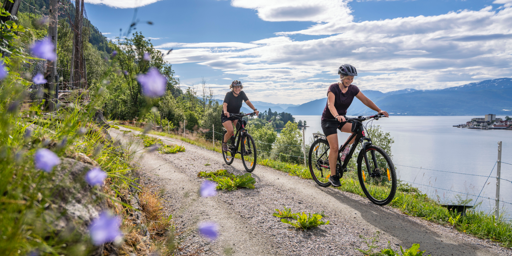

In [154]:
img_url = "https://github.com/itberrios/CV_projects/blob/main/stable_inpainting/assets/Fjord_Cycling.jpg?raw=true"
# img_url = "https://github.com/itberrios/CV_projects/blob/main/stable_inpainting/assets/Bicyclists-at-Glacier-Jacob-W.jpg?raw=true"
image = download_image(img_url) # .resize((512, 256)) # .resize((1024, 512))
_W, _H = image.size
W, H = _W//2, _H//2
W, H = 512, 256
image = image.resize((W, H))
image

So we have a nice picture of nature, but some pesky cyclists have gotten in the way! Thankfully we can use segmentation + stable diffusion to edit them out!

## Obtain segmentation model


In [155]:
seg_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

#### Prepare image for input to the model

In [156]:
inputs = seg_processor(image, return_tensors="pt")

with torch.no_grad():
    seg_outputs = seg_model(**inputs)

#### Post Process segmentation model results

In [157]:
seg_prediction = seg_processor.post_process_panoptic_segmentation(seg_outputs, target_sizes=[image.size[::-1]])[0]
print(seg_prediction.keys())

`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


### Display segmentation results

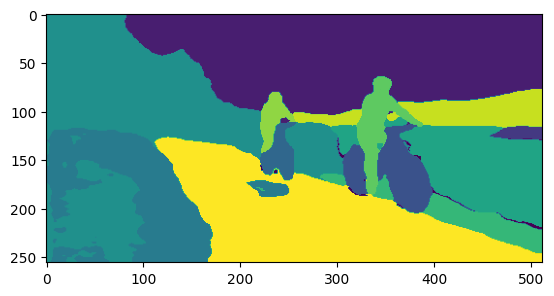

In [158]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(model, segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    # remove legend for better viz
    # ax.legend(handles=handles)

draw_panoptic_segmentation(seg_model, **seg_prediction)


Let's breakdown these results and understand what the model is giving us.

First let's see the segmented classes:

In [159]:
torch.unique(seg_prediction['segmentation'])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.int32)

Now make things more clear

In [160]:
segment_labels = {}

for segment in seg_prediction['segments_info']:
    segment_id = segment['id']
    segment_label_id = segment['label_id']
    segment_label = seg_model.config.id2label[segment_label_id]

    segment_labels.update({segment_id : segment_label})

segment_labels

{1: 'sky-other-merged',
 2: 'boat',
 3: 'bicycle',
 4: 'bicycle',
 5: 'grass-merged',
 6: 'tree-merged',
 7: 'sea',
 8: 'grass-merged',
 9: 'person',
 10: 'person',
 11: 'mountain-merged',
 12: 'dirt-merged'}

In [161]:
tgts = []
for k,v in segment_labels.items():
  if v in ['bicycle', 'person', 'backpack']:
    tgts.append(k)

tgts

[3, 4, 9, 10]

In [162]:
mask = np.array([(seg_prediction['segmentation'] == t).numpy() for t in tgts]).sum(axis=0).astype(np.uint8)*255

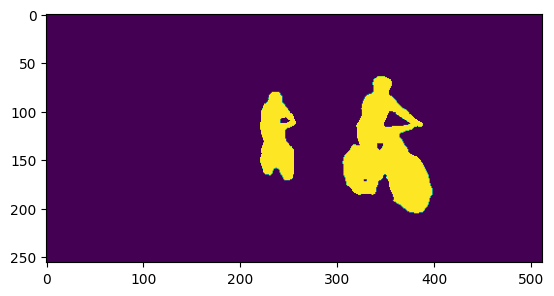

In [163]:
plt.imshow(mask)

In [147]:
people_mask = (seg_prediction['segmentation'] == 9) | (seg_prediction['segmentation'] == 10)
bicycle_mask = (seg_prediction['segmentation'] == 3) | (seg_prediction['segmentation'] == 4)
mask = people_mask | bicycle_mask

In [61]:
# display images
plt_people_mask = people_mask.numpy().astype(np.uint8) * 255
plt_bicycle_mask = bicycle_mask.numpy().astype(np.uint8) * 255
plt_mask = mask.numpy().astype(np.uint8) * 255

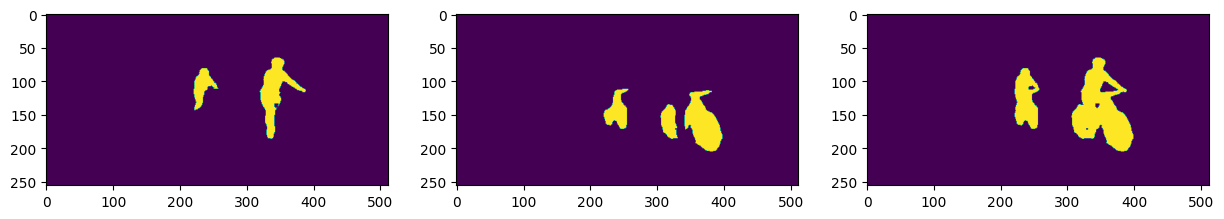

In [62]:
_, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(plt_people_mask)
ax[1].imshow(plt_bicycle_mask)
ax[2].imshow(plt_mask)

# Get Stable Diffusion model for inpainting

In [18]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


# Edit the image!

In [195]:
prompt = "a pokemon dancing"

guidance_scale=17.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=Image.fromarray(plt_mask), # ensure mask is same type as image
    height=H,
    width=W,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [196]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

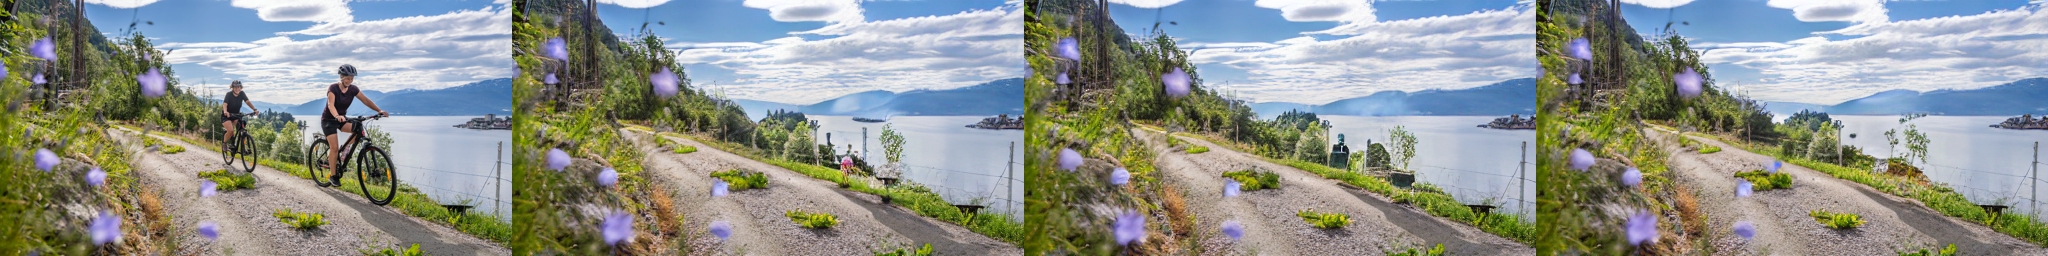

In [197]:
image_grid(images, 1, num_samples + 1)

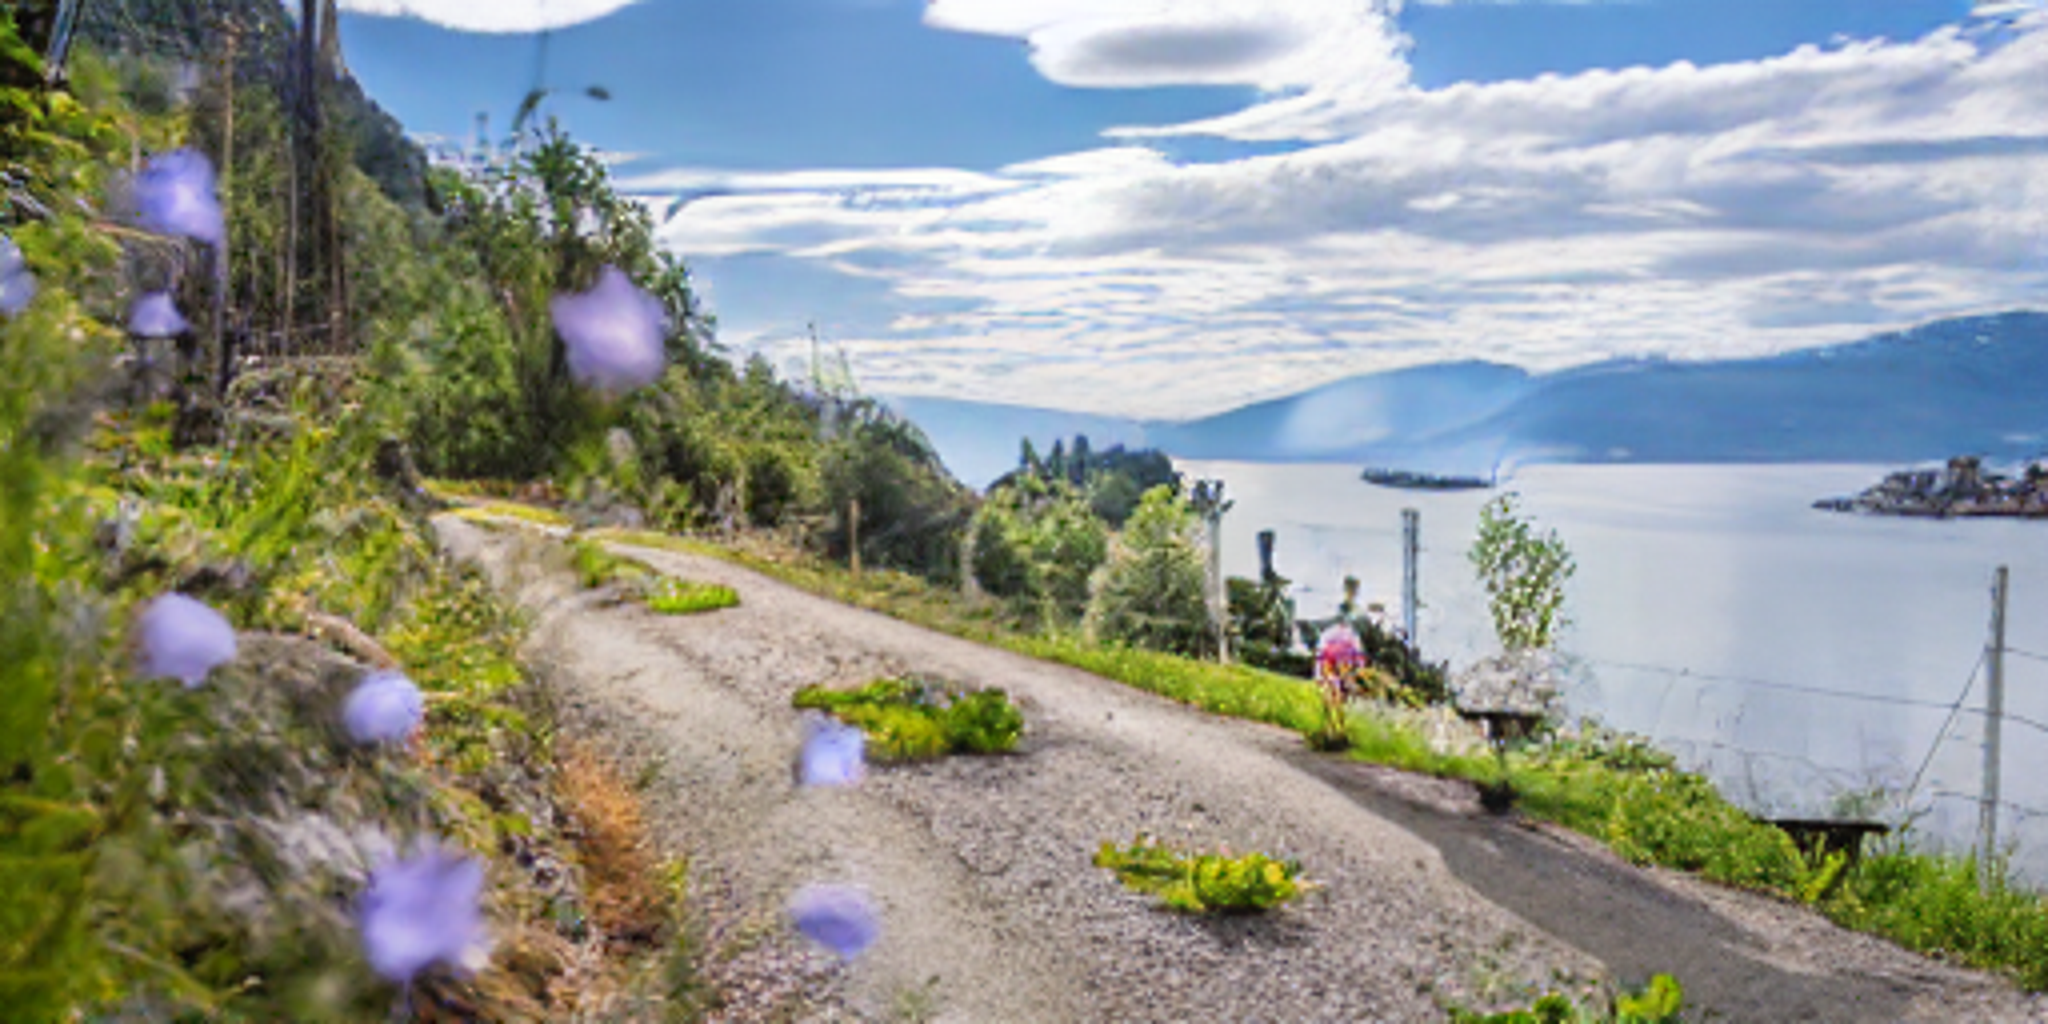

In [199]:
images[1].resize((2048, 1024))